In [1]:
import numpy as np
import matplotlib.pyplot as plt
import agama

In [2]:
# Set the default font size for all text in the plot
plt.rcParams.update({'font.size': 16})

20000 orbits complete (3.883e+04 orbits/s)
20000 orbits complete (4.107e+04 orbits/s)


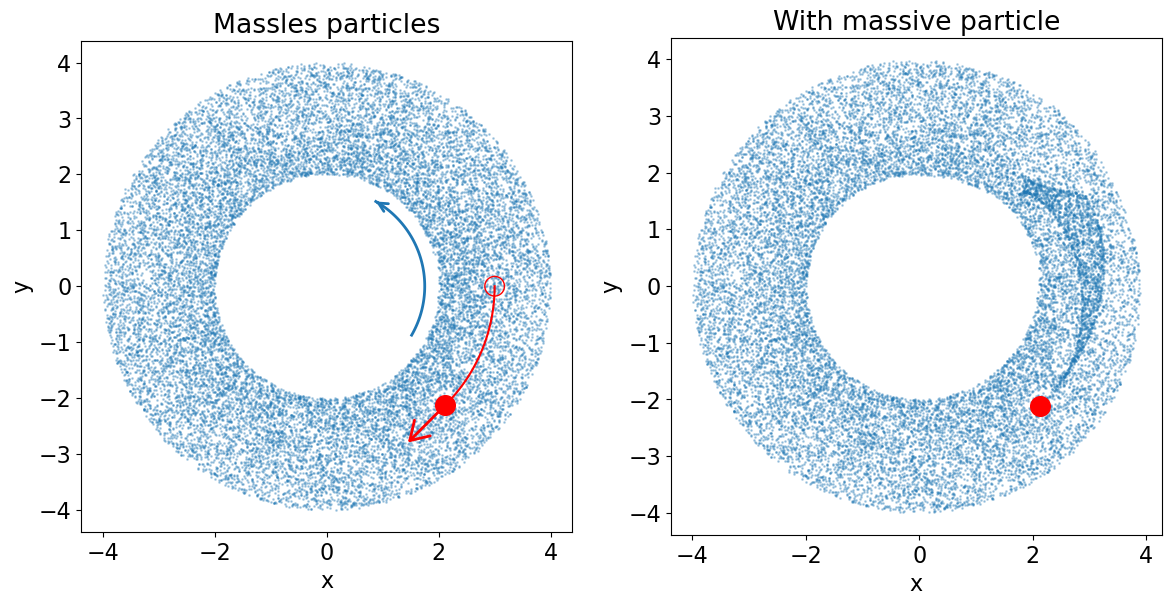

In [4]:
# Set up the logarithmic potential
v0 = 1.0  # Circular velocity (you can adjust this value)
plummer = dict(type='Logarithmic', v0=v0, axisRatioY=1.0, axisRatioZ=1.0, scaleRadius=0.0)
potential = agama.Potential(plummer)

# Parameters for the annulus
R = 3.0    # Central radius of the annulus
dR = 2   # Thickness of the annulus

# Define the moving potential component (e.g., a Plummer sphere)
M = 0.1        # Mass of the moving mass

epsilon = 0.15  # Softening length (scale radius for the Plummer potential)
nT_circ = 0.125 # Number of circular periods to integrate for

# Number of test particles
N = 20000

# Number of time steps for the special particle's orbit
nsteps = 1000

# Generate random radial distances within the annulus
radii = R + dR * (np.random.rand(N) - 0.5)

# Generate random azimuthal angles between 0 and 2π
phis = 2 * np.pi * np.random.rand(N)

# Positions in the plane z=0
x = radii * np.cos(phis)
y = radii * np.sin(phis)
z = np.zeros(N)

# Velocities for circular orbits 
vx = -v0 * np.sin(phis)
vy = v0 * np.cos(phis)
vz = np.zeros(N)

# Special particle at radius R, phi=0, moving in the opposite direction
x_sp = R
y_sp = 0
z_sp = 0

vx_sp = 0.
vy_sp = -v0  # Same or Opposite direction
vz_sp = 0

# Combine positions and velocities into initial conditions
positions = np.column_stack((x, y, z))
velocities = np.column_stack((vx, vy, vz))
ic_test_particles = np.hstack((positions, velocities))  # Shape: (N, 6)

positions_sp = np.array([x_sp, y_sp, z_sp])
velocities_sp = np.array([vx_sp, vy_sp, vz_sp])
ic_special_particle = np.hstack((positions_sp, velocities_sp))  # Shape: (6,)

# Compute the circular period
T_circ = 2 * np.pi * R / v0

# Integrate the orbits for N circular periods in the initial potential
# For test particles
orbits_test_particles = agama.orbit(
    potential=potential,
    ic=ic_test_particles,
    time=nT_circ*T_circ,
    trajsize=nsteps  # Start and end positions
)

# Extract positions at the end of integration
positions_end = np.array([orbit[1][-1, :3] for orbit in orbits_test_particles])

# For the special particle
orbit_special_particle = agama.orbit(
    potential=potential,
    ic=ic_special_particle,
    time=nT_circ*T_circ,
    trajsize=nsteps
)

# Extract times and trajectory of the special particle
times_sp = orbit_special_particle[0]          # Shape: (nsteps,)
trajectory_sp = orbit_special_particle[1]     # Shape: (nsteps, 6)
positions_sp = trajectory_sp[:, :3]
velocities_sp = trajectory_sp[:, 3:]

# Modify the potential to add a moving mass along the special particle's orbit
# Create the 'center' array with columns: time, x, y, z, vx, vy, vz
center_array = np.column_stack((times_sp, positions_sp, velocities_sp))  # Shape: (nsteps, 7)
potential_moving_mass = dict(
    type='Plummer',
    mass=M,
    scaleradius=epsilon,
    center=center_array)

# Create the composite potential
composite_potential = agama.Potential(plummer, potential_moving_mass)

# Integrate orbits of all test particles in the new composite potential
orbits_test_particles_new = agama.orbit(
    potential=composite_potential,
    ic=ic_test_particles,
    time=nT_circ*T_circ,
    trajsize=nsteps  # Start and end positions
)

# Extract positions at the end of integration
positions_end_new = np.array([orbit[1][-1, :3] for orbit in orbits_test_particles_new])

# Create the two-panel plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First panel: positions after the first integration
ax1.scatter(positions_end[:, 0], positions_end[:, 1], s=1, color='tab:blue', alpha=0.3)
ax1.scatter(positions_sp[-1, 0], positions_sp[-1, 1], color='red', s=200)
ax1.plot(positions_sp[:, 0], positions_sp[:, 1], color='red')
ax1.scatter(positions_sp[0, 0], positions_sp[0, 1], s=200, facecolors='none', edgecolors='red') 
ax1.set_title('Massles particles')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_aspect('equal')

# Add a red arrow indicating the direction of motion
arrow_length = 1  # Length of the arrow (you can adjust this value)
ax1.annotate(
    '',  # No text
    xy=(positions_sp[-1, 0] + arrow_length * velocities_sp[-1, 0], positions_sp[-1, 1] 
        + arrow_length * velocities_sp[-1, 1]),
    xytext=(positions_sp[-1, 0], positions_sp[-1, 1]),
    arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->,head_length=0.8,head_width=0.5', 
                    lw=2)
)


# Plot an arc (circle segment) with an arrow
arc_radius = R - 1.25*dR / 2  # Radius of the arc
arc_angle_start = -np.pi / 6  # Starting angle of the arc (adjust as needed)
arc_angle_end = np.pi / 3    # Ending angle of the arc (adjust as needed)
arc_angles = np.linspace(arc_angle_start, arc_angle_end, 100)

# Calculate x, y coordinates of the arc
arc_x = arc_radius * np.cos(arc_angles)
arc_y = arc_radius * np.sin(arc_angles)

# Plot the arc
ax1.plot(arc_x, arc_y, color='tab:blue', lw=2)

# Add an arrow to the end of the arc
ax1.annotate(
    '',  # No text
    xy=(arc_x[-1], arc_y[-1]),
    xytext=(arc_x[-2], arc_y[-2]),  # Slightly before the last point
    arrowprops=dict(facecolor='tab:blue', edgecolor='tab:blue', arrowstyle='->', lw=2)
)


# Second panel: positions after the second integration
ax2.scatter(positions_end_new[:, 0], positions_end_new[:, 1], s=1, color='tab:blue', alpha=0.3)
ax2.scatter(positions_sp[-1, 0], positions_sp[-1, 1], color='red', s=200)
ax2.set_title('With massive particle')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_aspect('equal')

plt.tight_layout()
# Adjust the space between the two panels
plt.subplots_adjust(wspace=0.2)  # Decrease this value to bring the panels closer


plt.savefig("../Figures/wake_formation.png", format="png", dpi=300, 
            facecolor='white', bbox_inches='tight')

plt.show()